In [1]:
import os
import pandas as pd; import numpy as np; 
from unidecode import unidecode
from matplotlib import pyplot as plt
%matplotlib inline
from gensim.models import word2vec

In [2]:
import warnings
warnings.filterwarnings("ignore")
warnings.warn('my warning')

Read in train and test

to train Word2Vec it is better not to remove stop words because the algorithm relies on the broader context of the sentence in order to produce high-quality word vectors.

Also better to not remove numbers

In [3]:
dft = pd.read_csv("data/finalnbadataonlyascii.csv")

Clean up data

In [4]:
# Import various modules for string cleaning
from bs4 import BeautifulSoup
import re
from nltk.corpus import stopwords

def review_to_wordlist( review, remove_stopwords=False ):
    # Function to convert a document to a sequence of words,
    # optionally removing stop words.  Returns a list of words.
    #
    # 0. ASCII encode
    review.encode('utf8', errors='ignore')
    review = unidecode(review)
    #fix_encoding = lambda s: s.decode('utf8', 'ignore')
    #review = fix_encoding(review)
    # 1. Remove HTML
    review_text = BeautifulSoup(review).get_text()
    #  
    # 2. Remove non-letters
    review_text = re.sub("[^a-zA-Z]"," ", review_text)
    #
    # 3. Convert words to lower case and split them
    words = review_text.lower().split()
    #
    # 4. Optionally remove stop words (false by default)
    if remove_stopwords:
        stops = set(stopwords.words("english"))
        words = [w for w in words if not w in stops]
    #
    # 5. Return a list of words
    return(words)

Expects sentences (in our case, we'll give it documents). 

Takes a list of lists

In [5]:
# Download the punkt tokenizer for sentence splitting
import nltk.data
#nltk.download()   

# Load the punkt tokenizer
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')

# Define a function to split a review into parsed sentences
def review_to_sentences( review, tokenizer, remove_stopwords=False ):
    # Function to split a review into parsed sentences. Returns a 
    # list of sentences, where each sentence is a list of words
    #
    # 1. Use the NLTK tokenizer to split the paragraph into sentences
    #review.encode('utf8', errors='ignore')
        
    fix_encoding = lambda s: s.decode('utf8', 'ignore')
    review = fix_encoding(review)
    raw_sentences = tokenizer.tokenize(review.strip())
    #
    # 2. Loop over each sentence
    sentences = []
    for raw_sentence in raw_sentences:
        # If a sentence is empty, skip it
        if len(raw_sentence) > 0:
            # Otherwise, call review_to_wordlist to get a list of words
            sentences.append( review_to_wordlist( raw_sentence, 
                                                 remove_stopwords ))
    #
    # Return the list of sentences (each sentence is a list of words,
    # so this returns a list of lists
    return sentences

Prepare for input

In [21]:
sent = sentences

In [6]:
# remove nans
def remove_nan(s):
    if isinstance(s, (float)):
        return str(s)
    try:
        f = float(s)
        if math.isnan(f):
            return ""
    except:
        return s

In [22]:

sentences = []
for row in dft['comment']:
    sentences += (review_to_sentences(remove_nan(row),tokenizer)) 

In [23]:
print(len(sentences))

952548


In [32]:
sentences  = [[unidecode(x) for x in sentence] for sentence in sentences]

In [35]:
sentences[2]

['kobe',
 'attempts',
 'this',
 'year',
 'and',
 'jason',
 'williams',
 'attempts',
 'in',
 'yeesh']

Choices I've made

* Architecture: continous bag of words, faster
* Training alg: softmax (default)
* Downsampling frequent words: 0.001 (taking advice from kaggle)
* Word Vec dim: 300 (tradeoff runtime and accracy of model. Choose smaller value)
* Context/window size: more is better, up to a point. Choose 10
* Worker threads: 4 processes on my comuputer
* Min word count: 40 (remove infrequent words)

In [ ]:
Sweet, this is already cythoned

In [7]:
# Import the built-in logging module and configure it so that Word2Vec 
# creates nice output messages
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s',\
    level=logging.INFO)

# Set values for various parameters
num_features = 300    # Word vector dimensionality                      
min_word_count = 40   # Minimum word count                        
num_workers = 4       # Number of threads to run in parallel
context = 10          # Context window size                                                                                    
downsampling = 1e-3   # Downsample setting for frequent words

In [36]:


# Initialize and train the model (this will take some time)

print "Training model..."
model = word2vec.Word2Vec(sentences, workers=num_workers, \
            size=num_features, min_count = min_word_count, \
            window = context, sample = downsampling)

# If you don't plan to train the model any further, calling 
# init_sims will make the model much more memory-efficient.
model.init_sims(replace=True)

# It can be helpful to create a meaningful model name and 
# save the model for later use. You can load it later using Word2Vec.load()
model_name = "300features_40minwords_10context"
model.save(model_name)

Training model...


Take a look at how it did

In [8]:
model = word2vec.Word2Vec.load("300features_40minwords_10context")

In [9]:
model.doesnt_match(['david','basketball','score','kobe'])

'david'

In [10]:
model.most_similar('kobe')

[('shaq', 0.6788023710250854),
 ('mj', 0.6442837715148926),
 ('dirk', 0.6076508164405823),
 ('duncan', 0.5596717596054077),
 ('kg', 0.5467815399169922),
 ('ai', 0.5400620102882385),
 ('kareem', 0.5384403467178345),
 ('hakeem', 0.5308566689491272),
 ('tour', 0.5138039588928223),
 ('wilt', 0.5112515687942505)]

In [11]:
model.most_similar('lakers')

[('suns', 0.7745028734207153),
 ('sixers', 0.7640694975852966),
 ('ers', 0.7258175611495972),
 ('nets', 0.703382134437561),
 ('mavs', 0.6891049146652222),
 ('kings', 0.6714465618133545),
 ('celtics', 0.6669562458992004),
 ('knicks', 0.6650993824005127),
 ('nuggets', 0.6638126373291016),
 ('bulls', 0.6013181805610657)]

In [12]:
model.doesnt_match(['kobe','shaq','magic','kareem','pierce'])

'pierce'

In [13]:
model.doesnt_match(['lebron','kobe','tracey','macgrady'])

'kobe'

In [14]:
model.doesnt_match(['shaq','yao','wilt','kareem','kidd'])

'kidd'

In [15]:
model.most_similar('yao')

[('tmac', 0.7082059383392334),
 ('ming', 0.6735073328018188),
 ('mcgrady', 0.6202747821807861),
 ('mutombo', 0.6183478832244873),
 ('olajuwon', 0.6099958419799805),
 ('hakeem', 0.6056028008460999),
 ('billups', 0.6023055911064148),
 ('ai', 0.5899838209152222),
 ('robinson', 0.5734567642211914),
 ('ewing', 0.5696166753768921)]

Making word reps

rows: words in vocab
col: size of feature vector

In [10]:
model.syn0.shape

(8643, 300)

In [11]:
np.mean(model.syn0)

-0.0018702373

In [12]:
import numpy as np  # Make sure that numpy is imported

def makeFeatureVec(words, model, num_features):
    # Function to average all of the word vectors in a given
    # paragraph
    #
    # Pre-initialize an empty numpy array (for speed)
    featureVec = np.zeros((num_features,),dtype="float32")
    #
    nwords = 0.
    # 
    # Index2word is a list that contains the names of the words in 
    # the model's vocabulary. Convert it to a set, for speed 
    index2word_set = set(model.index2word)
    #
    # Loop over each word in the review and, if it is in the model's
    # vocaublary, add its feature vector to the total
    for word in words:
        if word in index2word_set: 
            nwords = nwords + 1.
            featureVec = np.add(featureVec,model[word])
    # 
    # Divide the result by the number of words to get the average
    featureVec = np.divide(featureVec,nwords)
    return featureVec

def getAvgFeatureVecs(reviews, model, num_features):
    # Given a set of reviews (each one a list of words), calculate 
    # the average feature vector for each one and return a 2D numpy array 
    # 
    # Initialize a counter
    counter = 0.
    # 
    # Preallocate a 2D numpy array, for speed
    reviewFeatureVecs = np.zeros((len(reviews),num_features),dtype="float32")
    # 
    # Loop through the reviews
    for review in reviews:
        # Print a status message every 1000th review
        if counter%10000. == 0.:
            print "Review %d of %d" % (counter, len(reviews))
            
        # Call the function (defined above) that makes average feature vectors
        reviewFeatureVecs[counter] = makeFeatureVec(review, model, num_features)
        #
        # Increment the counter
        counter = counter + 1.
    return reviewFeatureVecs

In [13]:
# ****************************************************************
# Calculate average feature vectors for training and testing sets,
# using the functions we defined above. Notice that we now use stop word
# removal.

clean_comments = []
for review in dft["comment"]:
    fix_encoding = lambda s: s.decode('ascii', 'ignore')
    review = fix_encoding(remove_nan(review))
    clean_comments.append( review_to_wordlist( review, \
        remove_stopwords=True ))
trainDataVecs = getAvgFeatureVecs( clean_comments, model, num_features )

Review 0 of 533919
Review 10000 of 533919
Review 20000 of 533919
Review 30000 of 533919
Review 40000 of 533919
Review 50000 of 533919
Review 60000 of 533919
Review 70000 of 533919
Review 80000 of 533919
Review 90000 of 533919
Review 100000 of 533919
Review 110000 of 533919
Review 120000 of 533919
Review 130000 of 533919
Review 140000 of 533919
Review 150000 of 533919
Review 160000 of 533919
Review 170000 of 533919
Review 180000 of 533919
Review 190000 of 533919
Review 200000 of 533919
Review 210000 of 533919
Review 220000 of 533919
Review 230000 of 533919
Review 240000 of 533919
Review 250000 of 533919
Review 260000 of 533919
Review 270000 of 533919
Review 280000 of 533919
Review 290000 of 533919
Review 300000 of 533919
Review 310000 of 533919
Review 320000 of 533919
Review 330000 of 533919
Review 340000 of 533919
Review 350000 of 533919
Review 360000 of 533919
Review 370000 of 533919
Review 380000 of 533919
Review 390000 of 533919
Review 400000 of 533919
Review 410000 of 533919
Review

In [19]:
len(trainDataVecs[2])

300

In [24]:
dft['comment'][140]

'doooooooooeeeee'

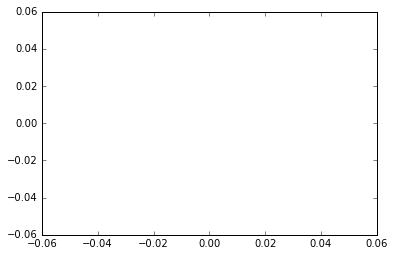

In [23]:
a = trainDataVecs[140]
plt.plot(a)
plt.show()

In [60]:
import pickle
pickle.dump(trainDataVecs,open('word2vec.p','wb'))

In [26]:
# Take everything that's missing from the data set and set = 0

#ALTERNATIVE IS TO TRHOW IT AWAY
for i in np.where(np.isnan(trainDataVecs))[0]:
    trainDataVecs[i] = np.zeros((300,))
pickle.dump(trainDataVecs,open('word2vec_zeros.p','wb'))

In [29]:
import pickle
pickle.dump(trainDataVecs,open('word2vec_zeros.p','wb'))

RF

In [ ]:
# Fit a random forest to the training data, using 100 trees
from sklearn.ensemble import RandomForestClassifier
forest = RandomForestClassifier( n_estimators = 100 )

print "Fitting a random forest to labeled training data..."
forest = forest.fit( trainDataVecs, train["sentiment"] )

# Test & extract results 
result = forest.predict( testDataVecs )

# Write the test results 
output = pd.DataFrame( data={"id":test["id"], "sentiment":result} )
output.to_csv( "Word2Vec_AverageVectors.csv", index=False, quoting=3 )